In [ ]:
# pip install pmdarima

In [ ]:
## For data
import pandas as pd
import numpy as np

## For plotting 
import matplotlib.pyplot as plt

In [ ]:
## for decomposition and outlier analysis 
from sklearn import preprocessing, svm

import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [ ]:
## hDD_cDD is a dataset of heating degree and cooling degree days staring in 1-jan-90 recorded in the midatlantic region of the united states
## first 4 rows are irrelevant to the model construction
hdd_df = pd.read_csv("/content/drive/MyDrive/hDD_cDD_(backto90) (1).csv")
hdd_df = hdd_df.iloc[4:]

In [ ]:
hdd_df.columns = ["month(m-y)",
                       "HDD"]

In [ ]:
## inverts the ts based on the first column so we have the df in ascending order
hdd_df = hdd_df.iloc[::-1]

In [ ]:
hdd_df = hdd_df.reset_index(drop=True)

In [ ]:
hdd_df.head()

,month(m-y),HDD
0,Jan-90,917.9632748
1,Feb-90,857.445848
2,Mar-90,760.6690671
3,Apr-90,482.5975034
4,May-90,283.6914135


In [ ]:
## creating a date column starting in 1-jan, eventually will use this as the index

date = pd.date_range(start='1/1/90', periods=len(hdd_df), freq='MS')
hdd_df.insert(1, 'date', date)
hdd_df['date'] = pd.to_datetime(hdd_df['date'], format='%d.%m.%Y')
hdd_df = hdd_df.drop(columns = "month(m-y)")

In [ ]:
# hdd_df = hdd_df.append(pd.Series(dtype = 'float64'), ignore_index=True)
# hdd_df.info()

In [ ]:
hdd_df['HDD'] = hdd_df['HDD'].astype('float64')

In [ ]:
hdd_ts = hdd_df.groupby('date')['HDD'].sum().rename('HDD')

In [ ]:
## original time series data 

hdd_ts.plot()

In [ ]:
## preliminarly finding the size of the dataset and giving the 20% index 

perc_size = .2
test_size = len(hdd_df) - len(hdd_df)*perc_size
print("Test from this index on: "+ str(test_size))

Test from this index on: 316.8


In [ ]:
# pip install arch

In [ ]:
# KPSS test to see if the data is stationary around the mean, null hypothesis is 
## the data is linear trend 

from arch.unitroot import KPSS

# stationary test 
kpss_test = KPSS(hdd_ts)

# test summary
print(kpss_test.summary().as_text())

In [ ]:
## method to plot the time series data 

def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(15,5)):    
   rolling_mean = ts.rolling(window=window).mean()    
   rolling_std = ts.rolling(window=window).std()
   plt.figure(figsize=figsize)    
   plt.title(ts.name)    
   plt.plot(ts[window:], label='Actual values', color="black")    
   if plot_ma:        
      plt.plot(rolling_mean, 'g', label='MA'+str(window),
               color="red")    
   if plot_intervals:
      lower_bound = rolling_mean - (1.96 * rolling_std)
      upper_bound = rolling_mean + (1.96 * rolling_std)
   plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                    color='lightskyblue', alpha=0.4)
   plt.legend(loc='best')
   plt.grid(True)
   plt.show()

The code that follows is repurposed from a towards data science article that is basically a tutorial on outlier detection and removal

In [ ]:
## next two cells are automated outlier detection using a support vector machine. Basically learns the boundaries of the distribution 
## "support" and classifies points outside that boundary 

def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found"
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

In [ ]:
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="nearest") ## current interpolation method nearest 
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black",
                  label="interpolated", legend=True)
    plt.show()
    return ts_clean

In [ ]:
## gets the outliers and displays their points and how the interpolation will smooth the seasonality
dtf_outliers = find_outliers(hdd_ts, perc=0.05)

# outliers index position 
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index

# exclude outliers 
hdd_ts_clean = remove_outliers(hdd_ts, outliers_idx=outliers_index_pos)

In [ ]:
## decompositional trend analysis of the clean time series...
## divides the dataset into three different valuation metrics, trend which basically analyzes the 
## increases and decreases in HDD over the long term. Seasonal evaluates the seasonality at monthly
## interval, 12 months. Residuals is basically the left over noise, the remainder between seasonality and 
## trend. Note: I am not a fan of gridlines most of the time but that could easily be implemented ax[x].grid(True)

decomposition = smt.seasonal_decompose(hdd_ts, freq=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False)
ax[0].plot(hdd_ts_clean)
ax[0].set_title('Original')
ax[0].grid(True)
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[1].grid(True)
ax[2].plot(seasonal)
ax[2].set_title('Seasonality')
ax[2].grid(True)
ax[3].plot(residual)
ax[3].set_title('Residuals')
ax[3].grid(True)

A lot of the code after this point is sourced and repurposed from a towards data science article walking through the steps of a time series analysis using prophet and tensorflow api, and then the new package pmdarima and the standard smt package, both of which provide some helpful tools for the SARIMAX model (can perform ARIMA, prophet, etc. for our purposes I chose SARIMAX because after some testing it seemed to have the lowest MAE or mean average error of 101.0, most of the article is subsequently irrelevant, but some of the code was helpful in building the model for seasonality forecasting), prediction error MAPE of 49%. SARIMAX means Seasonal AutoRegressive Integrated Moving Averages w eXogenous regressors. The AR part of the model views the current value as a weighted average of the previous values while the MA piece looks at the current value as weighted average sum of the past residuals (hence decomposition analysis). The eXongenous regressors are flexible but an exmaple would be something like holidays. 

In [ ]:
# for forecasting 
import pmdarima 
import statsmodels.tsa.api as smt 

In [ ]:
## spliting the training and test set, split is at 2016-01-01, meaning the test set is 20% of the training set
## I don't know how the round function is working given math not being imported but again most of this 
## code is sourced from that toward data science tutorial 

def split_train_test(ts, test=0.20, plot=True, figsize=(15,5)):
    ## define splitting point for our purposes 2016-01-01
    if type(test) is float:
        split = int(len(ts)*(1-test))
        perc = test
    elif type(test) is str:
        split = ts.reset_index()[ 
                      ts.reset_index().iloc[:,0]==test].index[0]
        perc = round(len(ts[split:])/len(ts), 2)
    else:
        split = test
        perc = round(len(ts[split:])/len(ts), 2)
    print("splitting at index: ", split, "|", 
          ts.index[split], "| test size:", perc, " ---")
    
    ## split ts
    ts_train = ts.head(split)
    ts_test = ts.tail(len(ts)-split)
    if plot is True:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, 
                               sharey=True, figsize=figsize)
        ts_train.plot(ax=ax[0], grid=True, title="Train", 
                      color="black")
        ts_test.plot(ax=ax[1], grid=True, title="Test", 
                     color="black")
        ax[0].set(xlabel=None)
        ax[1].set(xlabel=None)
        plt.show()
        
    return ts_train, ts_test

In [ ]:
## splits the time series for training and testing, again the 2016-05-01 is 
## referenced from index test size (395-317)

## import math to round up the test_size if it is a decimal value
import math 

hdd_ts_train, hdd_ts_test = split_train_test(hdd_ts, test=math.ceil(test_size)) ## hdd_ts_clean usually
# hdd_ts_train_clean, hdd_ts_test_clean = split_train_test(hdd_ts_clean, test=math.ceil(test_size))

In [ ]:
## basically evaluating all the stats from the forecast, this gets 
## a bit complex but understandble, mostly unchanged try-catch to 
## avoid missing statistics 

def utils_evaluate_forecast(dtf, title, plot=True, figsize=(20,13)):
    try:
        ## residuals
        dtf["residuals"] = dtf["ts"] - dtf["model"]
        dtf["error"] = dtf["ts"] - dtf["forecast"]
        dtf["error_pct"] = dtf["error"] / dtf["ts"]
        
        ## kpi, evaluating the "key performance indicators"
        residuals_mean = dtf["residuals"].mean()
        residuals_std = dtf["residuals"].std()
        error_mean = dtf["error"].mean()
        error_std = dtf["error"].std()
        mae = dtf["error"].apply(lambda x: np.abs(x)).mean()
        mape = dtf["error_pct"].apply(lambda x: np.abs(x)).mean()  
        mse = dtf["error"].apply(lambda x: x**2).mean()
        rmse = np.sqrt(mse)  #root mean squared error
        
        ## intervals
        dtf["conf_int_low"] = dtf["forecast"] - 1.96*residuals_std
        dtf["conf_int_up"] = dtf["forecast"] + 1.96*residuals_std
        dtf["pred_int_low"] = dtf["forecast"] - 1.96*error_std
        dtf["pred_int_up"] = dtf["forecast"] + 1.96*error_std
        
        ## plot
        if plot==True:
            fig = plt.figure(figsize=figsize)
            fig.suptitle(title, fontsize=20)   
            ax1 = fig.add_subplot(2,2, 1)
            ax2 = fig.add_subplot(2,2, 2, sharey=ax1)
            ax3 = fig.add_subplot(2,2, 3)
            ax4 = fig.add_subplot(2,2, 4)
            ### training
            dtf[pd.notnull(dtf["model"])][["ts","model"]].plot(color=["black","green"], title="Model", grid=True, ax=ax1)      
            ax1.set(xlabel=None)
            ### test
            dtf[pd.isnull(dtf["model"])][["ts","forecast"]].plot(color=["black","red"], title="Forecast", grid=True, ax=ax2)
            ax2.fill_between(x=dtf.index, y1=dtf['pred_int_low'], y2=dtf['pred_int_up'], color='b', alpha=0.2)
            ax2.fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)     
            ax2.set(xlabel=None)
            ### residuals
            dtf[["residuals","error"]].plot(ax=ax3, color=["green","red"], title="Residuals", grid=True)
            ax3.set(xlabel=None)
            ### residuals distribution
            dtf[["residuals","error"]].plot(ax=ax4, color=["green","red"], kind='kde', title="Residuals Distribution", grid=True)
            ax4.set(ylabel=None)
            plt.show()
            print("Training --> Residuals mean:", np.round(residuals_mean), " | std:", np.round(residuals_std))
            print("Test --> Error mean:", np.round(error_mean), " | std:", np.round(error_std),
                  " | mae:",np.round(mae), " | mape:",np.round(mape*100), "%  | mse:",np.round(mse), " | rmse:",np.round(rmse))
        
        return dtf[["ts","model","residuals","conf_int_low","conf_int_up", 
                    "forecast","error","pred_int_low","pred_int_up"]]
    
    except Exception as e:
        print("--- got error ---")
        print(e)

The next part below is a bit difficult conceptually. Basically instead of determing the best p,d,q values through manual testing, the pmdarima package uses auto_arima to evaluate the dataset and pick the best orders to fit the model. The tough part is the context of p,d,q and P,D,Q,s. p is the non-seasonal autoregressive order, d is the non-seasonal moving average and q is the non-seasonal differencing (residual). P is the seasonal AR order, D is the seasonal MA and Q is the seasonal differencing, the important piece here is s, which is basically the period of which we would see seasonality. Since I don't really know of any mathematical ways to determine this, I have arbitrally assumed 12 which is the annual cycle of the months. Also note, differencing is basically like taking the derivative of a function it takes the differce between the AR and MA to come up with more stationary data, which is a neccessary piece of the SARIMAX model.   

In [ ]:
## computing the seasonal index to be used as the exogenous predictor in the SARIMAX below
## this could be totally irrelevant just really something i think would be worth trying to
## sharpen the model

# from statsmodels.tsa.seasonal import seasonal_decompose 
# from dateutil.parser import parse

# ## multiplicticative seasonal component

# result_mul = seasonal_decompose(hdd_df['HDD'][-36:],
#                                 period=12,
#                                 extrapolate_trend='freq')
# seasonal_index = result_mul.seasonal[-12:].to_frame()
# seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# ## merge into the ts

# hdd_ts_clean['month'] = hdd_ts_clean.index.month
# hdd_ts_clean = pd.merge(hdd_df_clean, seasonal_index, how='left',on='month')
# hdd_df_clean.columns = ['date', 'HDD', 'seasonal_index']
# hdd_ts_clean.index = hdd_ts_clean.index 

In [ ]:
## this basically will tell us the best order and seasonal order to input to fit the model without having to manually do it
## it saves a lot of code by determining the p,d,q and P,D,Q,s wihtout having to actually test and come up with it 
## outselves. It also makes the data stationary. 

smodel = pmdarima.auto_arima(hdd_ts, start_p=1, start_q=1,
                            test='adf', max_p=3, max_q=3, m=12,
                            d=None, seasonal=True, start_P=0, D=1,
                            trace=True, error_action='ignore', 
                            suppress_warnings=True, stepwise=True)
print(smodel.summary())


# best_model = pmdarima.auto_arima(hdd_ts_clean,                                    
#                                  seasonal=True, stationary=False, 
#                                  m=12, information_criterion='aic', 
#                                  max_order=20,                                     
#                                  max_p=10, max_d=3, max_q=10,                                     
#                                  max_P=10, max_D=3, max_Q=10,                                   
#                                  error_action='ignore')
# print("best model --> (p, d, q):", best_model.order, " and  (P, D, Q, s):", best_model.seasonal_order)

mostly records Best model:  ARIMA(3,0,0)(2,1,0)[12], and best model --> (p,d,q): (0, 0, 1)  and (P,D,Q,s): (1, 0, 0, 12)

In [ ]:
## fitting the training and test set to the SARIMAX model

def fit_sarimax(ts_train, ts_test, order=(1,0,1), 
                seasonal_order=(0,0,0,0), exog_train=None, 
                exog_test=None, figsize=(15,10)):
    ## train
    model = smt.SARIMAX(ts_train, order=order, 
                        seasonal_order=seasonal_order, 
                        exog=exog_train, enforce_stationarity=False, 
                        enforce_invertibility=False).fit()
    dtf_train = ts_train.to_frame(name="ts")
    dtf_train["model"] = model.fittedvalues
    
    ## test
    dtf_test = ts_test.to_frame(name="ts")
    dtf_test["forecast"] = model.predict(start=len(ts_train), 
                            end=len(ts_train)+len(ts_test)-1, 
                            exog=exog_test)
    
    ## evaluate
    dtf = dtf_train.append(dtf_test)
    title = "ARIMA "+str(order) if exog_train is None else "ARIMAX "+str(order)
    title = "S"+title+" x "+str(seasonal_order) if np.sum(seasonal_order) > 0 else title
    dtf = utils_evaluate_forecast(dtf, figsize=figsize, title=title)
    return dtf, model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


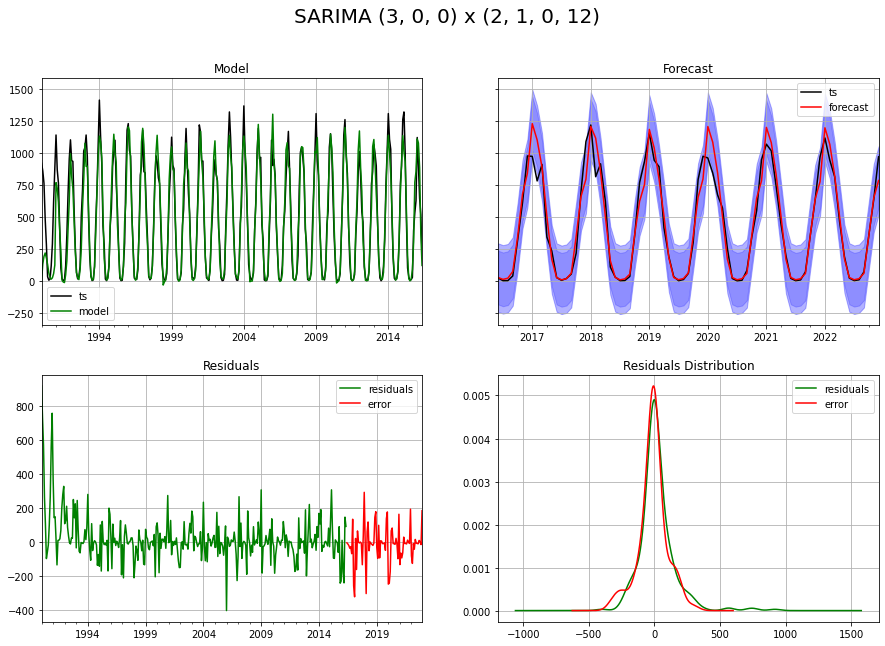

Training --> Residuals mean: 21.0  | std: 136.0
Test --> Error mean: -11.0  | std: 107.0  | mae: 69.0  | mape: inf %  | mse: 11433.0  | rmse: 107.0


In [ ]:
## forecasting the known future, see avg error is 61.0, with 41% prediction error

## this comes from running pmd arima on an adf test -- both are prediction error estimations that differ and result in stronger or weaker 
## results thats why i'm investigating 
dtf, model = fit_sarimax(hdd_ts_train, hdd_ts_test, order=(3,0,0),
                         seasonal_order=(2,1,0,12))

In [ ]:
## generating dates to index predictions  

def utils_generate_indexdate(start, end=None, n=None, freq="ms"):
    if end is not None:
        index = pd.date_range(start=start, end=end, freq=freq)
    else:
        index = pd.date_range(start=start, periods=n, freq=freq)
    index = index[1:]
    print("generating index date --> start:", index[0], 
          "| end:", index[-1], "| len:", len(index), "---")
    return index

In [ ]:
## plot the unknowns (i.e predicitons or forecast)

def utils_plot_forecast(dtf, zoom=30, figsize=(15,5)):
    ## interval
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    ## entire series
    dtf[["ts","forecast"]].plot(color=["black","red"], grid=True, ax=ax[0], title="History + Future")
    ax[0].fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3) 
          
    ## focus on last
    first_idx = dtf[pd.notnull(dtf["forecast"])].index[0]
    first_loc = dtf.index.tolist().index(first_idx)
    zoom_idx = dtf.index[first_loc-zoom]
    dtf.loc[zoom_idx:][["ts","forecast"]].plot(color=["black","red"], grid=True, ax=ax[1], title="Zoom on the last "+str(zoom)+" observations")
    ax[1].fill_between(x=dtf.loc[zoom_idx:].index, y1=dtf.loc[zoom_idx:]['conf_int_low'], 
                       y2=dtf.loc[zoom_idx:]['conf_int_up'], color='b', alpha=0.3)
    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]

In [ ]:
## method for the actual forecasting legwork rolling in the last two methods to index and plot the forecast 

def forecast_arima(ts, model, pred_ahead=None, end=None, freq="MS", zoom=30, figsize=(15,5)):
    ## fit
    model = model.fit()
    dtf = ts.to_frame(name="ts")
    dtf["model"] = model.fittedvalues
    dtf["residuals"] = dtf["ts"] - dtf["model"]
    
    ## index
    index = utils_generate_indexdate(start=ts.index[0], end=end, n=60, freq=freq)
    
    ## forecast
    preds = model.forecast(72)
    dtf = dtf.append(preds.to_frame(name="forecast"))
    
    ## plot
    dtf = utils_plot_forecast(dtf, zoom=zoom)
    return dtf

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


generating index date --> start: 1990-02-01 00:00:00 | end: 2022-12-01 00:00:00 | len: 395 ---


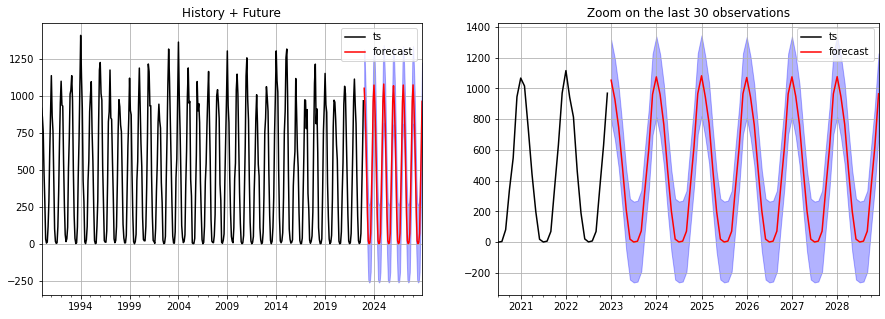

In [ ]:
model = smt.SARIMAX(hdd_ts, order=(3,0,0), seasonal_order=(2,1,0,12))

future = forecast_arima(hdd_ts, model, end="2022-12-01")


Interested to investigate why it's trending below 0 on some of the months, assuming it learned HDD's also have CDD's lol, should probably roll that in to our expectations. 

In [ ]:
# # prints the forecasting results to a csv  
# result = pd.DataFrame(future)
# result.columns = ['ts', 
#                   'model', 
#                    'residuals', 
#                   'conf_int_low', 
#                   'forecast', 
#                   'conf_int_up']
# result.to_csv("HDD_forecast3.6-28.csv")

In [ ]:
## need to try an LSTM neural network + mess with some of the test statistics 

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(ts):
  print('dicky-fuller: ')
  dft = adfuller(ts, autolag='AIC')
  dftout = pd.Series(dft[0:4], index=['TS', 'p-value', 'Lags Used', 'Number of Observations'])
  for key, value in dft[4].items():
    dftout['critical value (%s)' %key] = value
  print(dftout)

print(adf_test(hdd_ts_clean))

dicky-fuller: 
TS                         -4.999840
p-value                     0.000022
Lags Used                  17.000000
Number of Observations    378.000000
critical value (1%)        -3.447769
critical value (5%)        -2.869217
critical value (10%)       -2.570860
dtype: float64
None


Series is definitley stationary after some cleaning from pmdarima import datasets

In [ ]:
## Autocorrelation to determine whether the series should be differenced or
## pmdarima is a cheatcode for automatically performing tests and turning 
## them into visuals 
# from pmdarima import datasets

# pmdarima.plot_acf(hdd_ts_clean)